In [1]:
ROBBER = "R"
POLICE = "P"
BANK = "B"
EMPTY = "*"

grid = [
    [ROBBER,EMPTY,EMPTY,EMPTY],
    [EMPTY,BANK,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY,EMPTY],
    [EMPTY,EMPTY,EMPTY, POLICE]
]

for row in grid:
    print(' '.join(row))

R * * *
* B * *
* * * *
* * * P


In [2]:
class State:
    
    def __init__(self, robber_pos, police_pos):
        self.robber_pos = robber_pos
        self.police_pos = police_pos
        
    def __eq__(self, other):
        return isinstance(other, State) and self.robber_pos == other.robber_pos and self.police_pos == other.police_pos
    
    def __hash__(self):
        return hash(str(self.robber_pos) + str(self.police_pos))
    
    def __str__(self):
        return f"State(robber_pos={self.robber_pos}, police_pos={self.police_pos})"

In [3]:
STAY = 0
UP = 1
DOWN = 2 
LEFT = 3
RIGHT = 4

ACTIONS = [STAY, UP, DOWN, LEFT, RIGHT]

REWARD_BANK = 1
REWARD_EMPTY = 0
REWARD_CAUGHT = -10

START_ROBBER = [0,0]
START_POLICE = [3,3]

In [4]:
start_state = State(robber_pos=START_ROBBER, police_pos=START_POLICE)

In [5]:
from copy import deepcopy

def act(state,action_robber,action_police):
    def new_actor_pos(state,state_actor_pos,action):
        p = deepcopy(state_actor_pos)
        if action == UP:
            p[0] = max(0,p[0]-1)
        elif action == DOWN:
            p[0] = min(3, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1]-1)
        elif action == RIGHT:
            p[1] = min(3, p[1]+1)
        elif action == STAY:
            p = p
        else:
            raise ValueError(f"Unknown action {action}")
        return p
    
    pos_robber = new_actor_pos(state,state.robber_pos,action_robber)
    pos_police = new_actor_pos(state,state.police_pos,action_police)
    
    if pos_robber == pos_police:
        reward = REWARD_CAUGHT
    elif pos_robber == [1,1]:
        reward = REWARD_BANK
    else:
        reward = REWARD_EMPTY
        
    return State(robber_pos=pos_robber, police_pos=pos_police), reward


    

In [6]:
import numpy as np
import random
random.seed(42)

N_STATES = 16*16
ITERATIONS = 10000000

LAMBDA = 0.8
epsilons = [0.1, 0.3, 0.5] 

q_table = dict()

In [7]:
def q(state, action_robber=None):
    
    if state not in q_table:
        q_table[state] = np.zeros(len(ACTIONS))
    if action_robber is None: 
        return q_table[state]
    
    return q_table[state][action_robber]



In [8]:
def choose_action(state, eps_in):
    pos_robber = state.robber_pos
    pos_police = state.police_pos
    if pos_police[0] == 0:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[2],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[2],ACTIONS[3]])
        else:
            action_police = random.choice(ACTIONS[2:5])
    elif pos_police[0] == 3:
        if pos_police[1] == 0:
            action_police = random.choice([ACTIONS[1],ACTIONS[4]])
        elif pos_police[1] == 3:
            action_police = random.choice([ACTIONS[1],ACTIONS[3]])
        else:
            action_police = random.choice([ACTIONS[1],ACTIONS[3],ACTIONS[4]])
    elif pos_police[1] == 0:
        action_police = random.choice([ACTIONS[1],ACTIONS[2],ACTIONS[4]])
    elif pos_police[1] == 3:
        action_police = random.choice(ACTIONS[1:4])
    else: 
        action_police = random.choice(ACTIONS[1:])
        
    if random.random()<eps_in: 
        if pos_robber[0] == 0:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[2],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[0] == 3:
            if pos_robber[1] == 0:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[4]])
            elif pos_robber[1] == 3:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3]])
            else:
                action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[3],ACTIONS[4]])
        elif pos_robber[1] == 0:
            action_robber = random.choice([ACTIONS[0],ACTIONS[1],ACTIONS[2],ACTIONS[4]])
        elif pos_robber[1] == 3:
            action_robber = random.choice(ACTIONS[0:4])
        else: 
            action_robber = random.choice(ACTIONS)
    else:
        action_robber = np.argmax(q(state))
    
    return action_robber, action_police


In [9]:
index_matrix = np.arange(16).reshape((4,4))
state_index_matrix = np.arange(16*16).reshape((16,16))
policy_matrix = np.zeros((len(epsilons),16,16))+10 # 10, to make sure an action is choosen in all states

def state_matrix(state, i_eps):
    pos_police = state.police_pos
    pos_robber = state.robber_pos
    # police along rows, robber along columns
    col_r = index_matrix[pos_robber[0]][pos_robber[1]]
    row_p = index_matrix[pos_police[0]][pos_police[1]]
    state_index = state_index_matrix[row_p][col_r]
    
    best_move = np.argmax(q(state))
    policy_matrix[i_eps][row_p][col_r] = best_move
    
    return(state_index)


In [10]:
# SARSA Algorithm
sample_every = 10000

# Choose another intersting state to plot
other_state = State(robber_pos=[1,1], police_pos=[2,1])

times = []
values1 = np.zeros((len(epsilons),int(ITERATIONS/sample_every)))
values2 = np.zeros((len(epsilons),int(ITERATIONS/sample_every)))
rewards = np.zeros((len(epsilons),int(ITERATIONS/sample_every)))

for i in range(len(epsilons)):
    eps = epsilons[i]
    
    state = start_state
    action_robber, action_police = choose_action(start_state, eps)
    total_reward = 0

    n_updates_Q = np.zeros((len(ACTIONS),16*16))
    j = 0
    
    for t in range(ITERATIONS):
        new_eps = eps + (((eps/100)-eps)*t)/ITERATIONS
        next_state, reward = act(state, action_robber, action_police)
        next_action_robber, next_action_police = choose_action(next_state, new_eps)

        total_reward += reward

        state_index = state_matrix(state, i)
        n_updates_Q[action_robber][state_index] += 1
   
        alpha = 1/(n_updates_Q[action_robber][state_index]**(2/3))

        q(state)[action_robber] = q(state, action_robber) + \
                alpha * (reward + LAMBDA *q(next_state,next_action_robber) - q(state, action_robber))

        state = next_state
        action_robber = next_action_robber
        action_police = next_action_police

        if t%sample_every==0:
            # Look at the first state or other state taking the action with max q value
            values1[i][j] = max(q(start_state))
            values2[i][j] = max(q(other_state))
            rewards[i][j] = total_reward
            j += 1
            if i == 0:
                times.append(t)
            
        if t%100000==0:
            #print(max(q(start_state)))
            #print(t)
        
    print(n_updates_Q)
    q_table.clear()

0.0
0
1.3839836143156468
100000
1.6401604511289998
200000
1.8418316665588075
300000
2.025269041045922
400000
2.1404062747761188
500000
2.1943623785228397
600000
3.1091120154627316
700000
3.084050022848817
800000
3.095139045465666
900000
3.1096582677386473
1000000
3.1138310935904507
1100000
3.111037625133109
1200000
3.107459882032039
1300000
2.9868152207183662
1400000
3.009550595952607
1500000
2.9458003709458827
1600000
2.991661723619526
1700000
3.039616010762006
1800000
3.051377224084844
1900000
3.061184107483496
2000000
3.064712276947921
2100000
3.0706842714200198
2200000
3.086265974692672
2300000
3.091490857181269
2400000
3.09676716358054
2500000
3.062308354513899
2600000
3.0658911286417934
2700000
3.097241904365206
2800000
3.10678304718586
2900000
3.113035946388009
3000000
3.121851985474986
3100000
3.1241660750782616
3200000
3.1286666956812903
3300000
3.130400655096785
3400000
3.0669731345340807
3500000
3.080026103231502
3600000
3.091655703296522
3700000
3.098632947736601
3800000
3.

2.8714466252174358
14500000
2.873865405150493
14600000
2.873865405150493
14700000
2.873865405150493
14800000
2.873865405150493
14900000
[[9.9900e+02 1.2300e+03 8.3400e+02 ... 1.4900e+02 1.7000e+01 1.0000e+01]
 [0.0000e+00 9.0000e+00 0.0000e+00 ... 3.8700e+02 1.2100e+02 2.0000e+00]
 [9.3000e+01 2.1576e+04 2.5400e+02 ... 0.0000e+00 0.0000e+00 6.0000e+00]
 [0.0000e+00 1.1890e+03 7.3000e+01 ... 3.6000e+01 1.2500e+02 0.0000e+00]
 [1.0700e+02 1.2470e+03 7.6000e+01 ... 4.4000e+01 1.5000e+01 0.0000e+00]]
0.0
0
1.2651545822321115
100000
1.2345823280099626
200000
1.1230079769050736
300000
1.178007835103779
400000
1.2036654938203002
500000
1.3160878640801377
600000
1.327662765186775
700000
1.3448639580356505
800000
1.2582715240450104
900000
1.2187874670835726
1000000
1.2557024533926022
1100000
1.2747834277461934
1200000
1.3029748395772305
1300000
1.3992068184240234
1400000
1.3765472309000304
1500000
1.299174244686754
1600000
1.3271089395568336
1700000
1.3498912713225828
1800000
1.3123412657600313

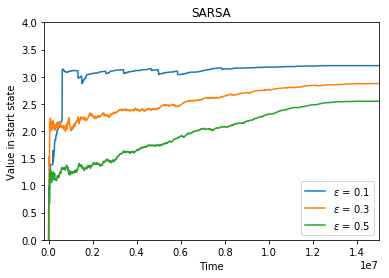

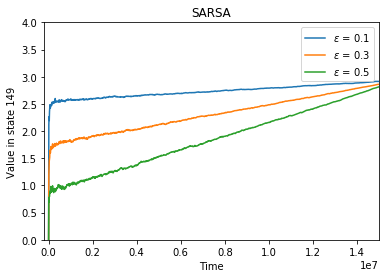

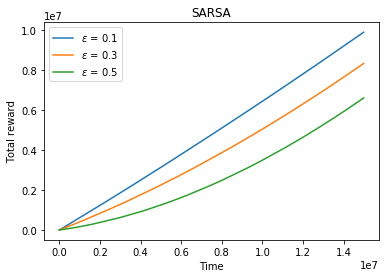

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(len(epsilons)):
    plt.plot(times,values1[i][:], label = '$\epsilon$ = '+ str(epsilons[i]))
plt.title("SARSA")
plt.xlabel("Time")
plt.ylabel("Value in start state")
plt.xlim(-200000, ITERATIONS)
plt.ylim(0, 4.0)
plt.legend()
plt.show()

for i in range(len(epsilons)):
    plt.plot(times,values2[i][:], label = '$\epsilon$ = '+ str(epsilons[i]))
plt.title("SARSA")
plt.xlabel("Time")
plt.ylabel("Value in state 149")
plt.xlim(-200000, ITERATIONS)
plt.ylim(0, 4.0)
plt.legend()
plt.show()

for i in range(len(epsilons)):
    plt.plot(times,rewards[i][:],label ='$\epsilon$ = '+ str(epsilons[i]))
plt.title("SARSA")
plt.xlabel("Time")
plt.ylabel("Total reward")
plt.legend()
plt.show()

In [12]:
print(len(q_table))


0


In [18]:
def get_spec_policy(grid_index_police):
    for i in range(len(epsilons)):
        print('Epsilon = '+str(epsilons[i]))
        #print(policy_matrix[i][:][:])
        fixed_police = policy_matrix[i][grid_index_police][:]
        fixed_police_policy = fixed_police.reshape(4,4)
        police_idx = np.where(index_matrix==grid_index_police)
        fixed_police_policy[police_idx[0][0]][police_idx[1][0]] = 9
        print(fixed_police_policy)
get_spec_policy(11)

Epsilon = 0.1
[[4. 2. 3. 3.]
 [4. 0. 3. 3.]
 [1. 1. 1. 9.]
 [4. 1. 0. 3.]]
Epsilon = 0.3
[[4. 2. 3. 3.]
 [4. 0. 3. 3.]
 [1. 1. 1. 9.]
 [1. 1. 3. 3.]]
Epsilon = 0.5
[[2. 2. 3. 3.]
 [4. 0. 3. 3.]
 [1. 1. 3. 9.]
 [1. 1. 3. 3.]]
